# Solving a QUBO with QAOA

In this notebook we look at how QAOA can be used to solve a simple quadratic unconstrained binary optimisation problem. We tackle the problem in Section 2 of __[this tutorial](https://arxiv.org/pdf/1811.11538.pdf)__.

## Problem definition as QUBO

The problem to be solved is to find the minimum function value, and corresponding configuration of variables, of 

\begin{equation}
y = -5x_1 -3x_2 -8x_3 -6x_4 + 4x_1x_2 + 8x_1x_3 + 2x_2x_3 + 10x_3x_4
\end{equation}

Here the variables $x_i$, $i = 1,...,4$ are binary. Observe that in the linear part (the first 4 terms) all of the variables would ideally be equal to 1 in order to minimise the function. However, the quadratic part encodes penalties for having different variable combinations.

Note that in the linear part, we can simply square all of the variables, since $x_i = x_i^2$ for binary variables. We then transform the problem to minimisation of

\begin{eqnarray}
y^{\prime} &=& -5x_1^2 -3x_2^2 -8x_3^2 -6x_4^2 + 4x_1x_2 + 8x_1x_3 + 2x_2x_3 + 10x_3x_4 \\
&=& \left(\begin{matrix} x_4 & x_3 & x_2 & x_1\end{matrix}\right)
\left(\begin{matrix}
-6 & 5 & 0 & 0 \\
5 & -8 & 1 & 4 \\
0 & 1 & -3 & 2 \\
0 & 4 & 2 & -5
\end{matrix}
\right)
\left(\begin{matrix} x_4\\ x_3 \\ x_2 \\ x_1 \end{matrix}\right)
\end{eqnarray}

We have ordered the variables in the binary strings such that $x_1$ appears as the least significant bit, which corresponds to the general convention in the quantum computing community (and in particular in most quantum programming environments). Let's plot the function to see what the energy landscape looks like.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

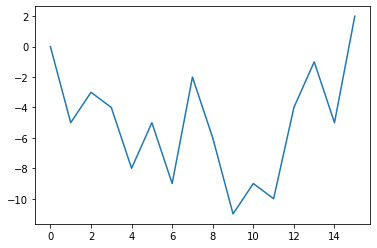

In [2]:
def func_y(config):
    
    #matr = np.array([[-5, 2, 4, 0], [2, -3, 1, 0], [4, 1, -8, 5], [0, 0, 5, -6]])
    matr = np.array([[-6, 5, 0, 0], [5, -8, 1, 4], [0, 1, -3, 2], [0, 4, 2, -5]])
    
    return config @ matr @ config

def num_2_bin(num):
    
    bin_str = np.binary_repr(num, width=4)
    bin_arr = np.array([int(x) for x in bin_str])
    
    return bin_arr

y_vals = [func_y(num_2_bin(i)) for i in range(16)]
plt.plot(y_vals)
plt.show()

The optimal solution is $x_1 = x_4 = 1$, $x_2 = x_3 = 0$, i.e. the bitstring 1001 (the binary representation of the number 9). Its corresponding function value is -11.

## Mapping to QAOA

To solve using QAOA, we would naively just associate each variable with the $Z$ value of a spin. However, there are a couple of implementation details we need to take into account. Firstly, unlike how we took the square of the binary variables $x_j$ to arrive at a QUBO, we can't use the trick of squaring the qubit $Z$ operator, because this would simply result in the identity operation. We would therefore just implement the linear terms in their original form, albeit with the following modification:

\begin{equation}
x_i \leftrightarrow \frac{\mathbb{I} - Z_j}{2}
\end{equation}

This ensures that a spin in state $|0\rangle$ produces zero contributiion to the cost function, while a spin in state $|1\rangle$ adds 1 to the total cost function.

Turning to the polynomial terms, in the original problem above, it is sufficient for just one of the variables $x_i$ or $x_j$ to be 0 for the term $x_ix_j$ to be zero. This does not carry over to measurements of the $Z$ operator for qubits, since $Z_iZ_j = \pm1$ if $i=j$ (+) or $i\neq j$ (-). However, if we choose the operator $(\mathbb{I} - Z_i)(\mathbb{I} - Z_j)/4 = (\mathbb{I} - Z_i - Z_j + Z_iZ_j)/4$, we are able to implement the desired cost function

\begin{equation}
\left(
\begin{matrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 
\end{matrix}
\right)
\end{equation}

Our Hamiltonian is then


\begin{eqnarray}
H_y &=& -\frac{1}{2}\left[5(\mathbb{I} - Z_1) + 3(\mathbb{I} - Z_2) + 8(\mathbb{I} - Z_3) + 6(\mathbb{I} - Z_4)\right] \\ 
&+& \frac{1}{4}\left[4(\mathbb{I} - Z_1)(\mathbb{I} - Z_2) + 8(\mathbb{I} - Z_1)(\mathbb{I} - Z_3) + 2(\mathbb{I} - Z_2)(\mathbb{I} - Z_3) + 10(\mathbb{I} - Z_3)(\mathbb{I} - Z_4)\right]
\end{eqnarray}

Let's now set the problem up and proceed to solve it using QAOA. First we import all the packages we need.

In [2]:
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from pyquil.unitary_tools import lifted_pauli
from entropica_qaoa.qaoa.parameters import StandardParams, ExtendedParams, FourierParams
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim
from scipy.optimize import minimize

The linear part of the Hamiltonian:

In [3]:
# We could provide a method to convert a given function to the corresponding Hamiltonian
ham_lin = -0.5*PauliSum.from_compact_str('(-5)*Z1 + (-3)*Z2 + (-8)*Z3 + (-6)*Z4 + 22*I')
print(ham_lin)

(2.5-0j)*Z1 + (1.5-0j)*Z2 + (4-0j)*Z3 + (3-0j)*Z4 + (-11+0j)*I


The quadratic part of the Hamiltonian:

In [4]:
ham_poly = 0.25*PauliSum.from_compact_str('4*Z1*Z2 + 4*I + (-4)*Z1 + (-4)*Z2 + 8*Z1*Z3 + 8*I + (-8)*Z1 + (-8)*Z3')
ham_poly += 0.25*PauliSum.from_compact_str('2*Z2*Z3 + 2*I + (-2)*Z2 + (-2)*Z3 + 10*Z3*Z4 + 10*I + (-10)*Z3 + (-10)*Z4')

Sum them up, and check that the eigenvalues correspond to the function values of $y$ that we computed above:

In [5]:
ham = ham_lin + ham_poly

In [6]:
ham_matrix = lifted_pauli(ham, ham.get_qubits())
print(np.diag(ham_matrix))
print('')
print(y_vals)

[  0.+0.j  -5.+0.j  -3.+0.j  -4.+0.j  -8.+0.j  -5.+0.j  -9.+0.j  -2.+0.j
  -6.+0.j -11.+0.j  -9.+0.j -10.+0.j  -4.+0.j  -1.+0.j  -5.+0.j   2.+0.j]



NameError: name 'y_vals' is not defined

## Solution with `StandardParams`

Let's start with `StandardParams`. We'll see how we do with $p=3$ timesteps, using Cobyla as our optimiser, and the `linear_ramp_from_hamiltonian` function to set up our inital parameters.

In [8]:
p = 3
standard_params = StandardParams.linear_ramp_from_hamiltonian(ham,p)

In [9]:
cost_std = QAOACostFunctionOnWFSim(ham,standard_params)
res_std = minimize(cost_std, standard_params.raw(), method = 'Cobyla')

In [10]:
res_std

     fun: -9.481737401651825
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 217
  status: 1
 success: True
       x: array([0.57669517, 0.36696255, 0.1714248 , 0.13199443, 0.27704162,
       0.31672819])

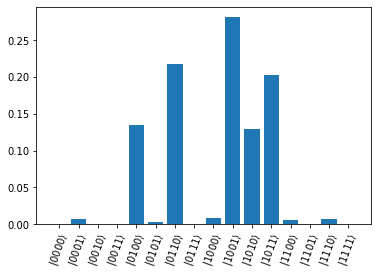

In [11]:
state = cost_std.get_wavefunction(res_std.x)
probs = state.probabilities()
labels = [r'$\left|{0:04b}\right>$'.format(i) for i in range(16)]
plt.bar(range(16),probs)
plt.xticks(range(16), labels, rotation=70);

The most probable state is $|1001\rangle$, which does indeed correspond to the minimum energy configuration of the variables. However, if we were to sample from a quantum computer, the above distribution would not allow us to conclude with sufficient confidence that we have found the solution.

Let's try increasing $p$ to see how more likely we are to obtain the optimal solution. To do this, we'll define a simple convenience function.

In [12]:
def state_prob_p(p):
    
    standard_params = StandardParams.linear_ramp_from_hamiltonian(ham,p)
    cost_std = QAOACostFunctionOnWFSim(ham,standard_params)
    res_std = minimize(cost_std, standard_params.raw(), method = 'Cobyla')
    state = cost_std.get_wavefunction(res_std.x)
    probs = state.probabilities()
    
    return probs[9] # The bitstring 1001 is the 9th entry of the vector of probabilities

In [17]:
# Running this cell should take 2 or 3 minutes with the upper value of p as 12
p_vals = np.arange(1,13)
probability_opt_state = [state_prob_p(i) for i in p_vals]

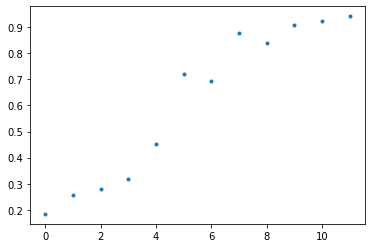

In [18]:
plt.plot(p_vals,probability_opt_state,'.')
plt.show()

Clearly the optimal bit string probability approaches unity with increasing $p$. What do the optimal parameters look like? Let's focus on the case $p=10$, for example.

In [21]:
standard_p10 = StandardParams.linear_ramp_from_hamiltonian(ham,10)
cost_p10 = QAOACostFunctionOnWFSim(ham,standard_p10)
res_p10 = minimize(cost_p10, standard_p10.raw(), method = 'Cobyla')

We can plot the optimal parameters vs. the circuit iteration steps as follows:

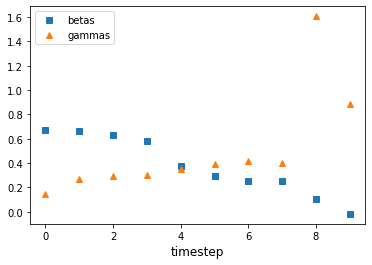

In [22]:
standard_p10.update_from_raw(res_p10.x)
standard_p10.plot()

Generally, the parameters appear to be relatively smooth functions (barring the apparent outlier in the `gammas`). We might therefore investigate the `Fourier` parametrisation as an alternative.

## Solution with `FourierParams`

First we define a convenience function:

In [7]:
def state_prob_fourier(p,q):
    
    fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,p,q)
    cost = QAOACostFunctionOnWFSim(ham,fourier_params)
    res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*p})
    state = cost.get_wavefunction(res.x)
    probs = state.probabilities()
    
    return probs[9] # The bitstring 1001 is the 9th entry of the vector of probabilities

Let's look again at the case $p=10$, for different values of $q$. 

In [8]:
fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,10,10)
fourier_params

Hyperparameters:
	register: [1, 2, 3, 4]
	qubits_singles[1, 3, 4]
	qubits_pairs[[1, 2], [1, 3], [2, 3], [3, 4]]
Parameters:
	v: [0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
	u: [0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

In [11]:
q_vals = [1, 5] #np.arange(1,11)
opt_prob = [state_prob_fourier(10,q) for q in q_vals]

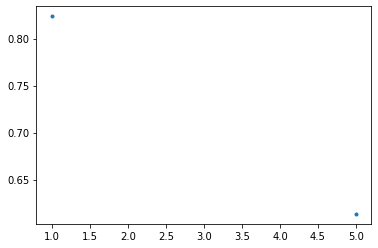

In [12]:
plt.plot(q_vals,opt_prob,'.')
plt.show()

Interestingly, different values of $q$ can give significantly different results, even though the optimisation procedure converges. 

In [11]:
def state_prob_fourier_perturb(p,q,R):
    
    fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,p,q)
    cost = QAOACostFunctionOnWFSim(ham,fourier_params)
    res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*p})
    
    prob_opt_state = []
    for i in range(R):
    
        perturb_params = res.x + i*np.random.rand(len(res.x))
        state = cost.get_wavefunction(perturb_params)
        probs = state.probabilities()   
        prob_opt_state.append(probs[9]) # The bitstring 1001 is the 9th entry of the vector of probabilities
    
    return max(prob_opt_state)

In [14]:
R = 20
q_vals = np.arange(1,5)
opt_prob = [state_prob_fourier_perturb(10,q,R) for q in q_vals]

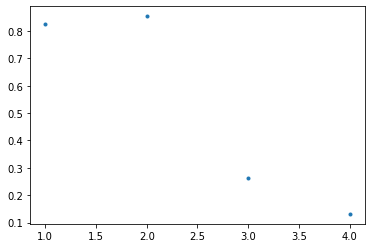

In [15]:
plt.plot(q_vals,opt_prob,'.')
plt.show()

In [17]:
fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,10,2)
cost = QAOACostFunctionOnWFSim(ham,fourier_params)
res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*10})
res.x

array([0.29316159, 0.00997137, 0.21293014, 0.01477254])

In [18]:
fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,10,1)
cost = QAOACostFunctionOnWFSim(ham,fourier_params)
res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*10})
res.x

array([-0.28484122, -0.20314005])

In [19]:
fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,10,3)
cost = QAOACostFunctionOnWFSim(ham,fourier_params)
res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*10})
res.x

array([ 0.30912172, -0.32921358, -0.19571799,  0.07911352, -0.2884658 ,
       -0.18004924])

In [21]:
def compare_fourier_states(p,q):
    
    fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,p,q)
    cost = QAOACostFunctionOnWFSim(ham,fourier_params)
    direct_cost = cost(fourier_params.raw())
    res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*p})
    state = cost.get_wavefunction(res.x)

    return direct_cost, state

In [22]:
cost1, state1 = compare_fourier_states(10,1)

In [23]:
cost2, state2 = compare_fourier_states(10,2)

In [24]:
cost3, state3 = compare_fourier_states(10,3)

In [25]:
cost4, state4 = compare_fourier_states(10,4)

In [26]:
print([cost1, cost2, cost3, cost4])

[-5.250643976172608, -5.250643976172608, -5.250643976172608, -5.250643976172608]


In [32]:
ovlap12 = np.vdot(state1.amplitudes, state2.amplitudes)
ovlap12

(1.0000000000000009+0j)

In [33]:
ovlap13 = np.vdot(state1.amplitudes, state3.amplitudes)
ovlap13

(1.0000000000000009+0j)

In [85]:
def state_prob_fourier(p,q):
    
    fourier_params = FourierParams.linear_ramp_from_hamiltonian(ham,p,q)
    print(fourier_params)
    print("")
    cost = QAOACostFunctionOnWFSim(ham,fourier_params)
    cost_direct = cost(fourier_params.raw())
    res = minimize(cost, fourier_params.raw(), method = 'Cobyla', options={"maxiter" : 500*p})
    print(res.x)
    print("")
    state = cost.get_wavefunction(res.x)
    print(state.amplitudes)
    print("")
    probs = state.probabilities()
    print(probs[9])

In [86]:
state_prob_fourier(10,1)

Hyperparameters:
	register: [1, 2, 3, 4]
	qubits_singles[1, 3, 4]
	qubits_pairs[[1, 2], [1, 3], [2, 3], [3, 4]]
Parameters:
	v: [0.35]
	u: [0.35]


[-0.28484122 -0.20314005]

[ 0.00542871-0.00244502j  0.01151643-0.01574343j  0.01075178-0.00739744j
  0.02395431-0.00287423j -0.03341247-0.08675848j -0.00311101+0.01844464j
 -0.15111139-0.18603979j -0.02967582+0.01570758j -0.00154285-0.01344018j
  0.74187167-0.522958j    0.01460868+0.05626045j  0.30946172+0.06145817j
 -0.01666545+0.01513348j -0.0407002 -0.01814528j -0.01535522+0.00668231j
 -0.0209098 +0.03303586j]

0.8238586518628618


In [87]:
state_prob_fourier(10,2)

Hyperparameters:
	register: [1, 2, 3, 4]
	qubits_singles[1, 3, 4]
	qubits_pairs[[1, 2], [1, 3], [2, 3], [3, 4]]
Parameters:
	v: [0.35 0.  ]
	u: [0.35 0.  ]


[0.29316159 0.00997137 0.21293014 0.01477254]

[-0.00252938-0.00931557j  0.01062624+0.00533401j  0.0079307 -0.01591686j
  0.00673219-0.02163814j  0.03010835+0.07924197j -0.01836393-0.00177901j
  0.01250499+0.22412031j -0.01376186+0.03497458j  0.00184552+0.02221852j
  0.89591101+0.2257123j   0.0082895 -0.04074264j  0.2592198 -0.11718394j
 -0.02493997+0.0213085j   0.00204576+0.02091686j -0.01950712+0.01484122j
  0.02445215-0.01178232j]

0.8536025811314355


In [88]:
state_prob_fourier(10,3)

Hyperparameters:
	register: [1, 2, 3, 4]
	qubits_singles[1, 3, 4]
	qubits_pairs[[1, 2], [1, 3], [2, 3], [3, 4]]
Parameters:
	v: [0.35 0.   0.  ]
	u: [0.35 0.   0.  ]


[ 0.30912172 -0.32921358 -0.19571799  0.07911352 -0.2884658  -0.18004924]

[ 0.07270281-0.0635645j  -0.08601005+0.27822385j  0.02431328+0.18002524j
 -0.15049697+0.05269162j -0.14632579+0.09075276j -0.15866262-0.08149817j
  0.0950033 +0.04393202j -0.10086752+0.16274806j  0.22458002+0.09468539j
 -0.25216903-0.44708904j -0.0205028 +0.10467586j -0.59795335+0.03411181j
  0.11815936+0.04006375j -0.11792246+0.07992462j -0.0433709 +0.00861815j
 -0.08329487+0.02528712j]

0.2634778282357807
